In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [134]:
companies_selected = pd.read_excel("Companies.xlsx")

In [135]:
companies_selected.shape

(79, 5)

In [136]:
companies_selected.head()

,Company Name,Industry,Beta Value,Grade,TSR
0,NextEra Energy (NEE),Utilities,0.49,B,53.47
1,Duke Energy (DUK),Utilities,0.38,C,57.51
2,Atmos Energy (ATO),Utilities,0.50,B,54.13
3,Avangrid (AGR),Utilities,0.34,A,-8.57
4,Otter Tail (OTTR),Utilities,0.69,A,87.72


In [137]:
# since TSR is in % we will grade wight in % as well
grade_weight = {"A": 90, "B": 80, "C": 70, "D": 60, "E": 50, "F": 40}
companies_selected["GradeWeight"] = companies_selected["Grade"].map(grade_weight)

In [138]:
def calculate_grade_score(data, x):
    return (1 - x) * data["TSR"] + x * data["GradeWeight"]

In [139]:
def monte_carlo_simulation(
    data, max_industry_allocation=0.16, max_stock_allocation=0.045, target_beta=1.0
):
    best_portfolio = None
    best_portfolio_beta = float("inf")
    best_run = None

    for iteration in range(
        65000, 80000
    ):  # We want to keep the grade wight at a minumum of 0.65 of the total caluclation
        weight_factor = iteration / 100000  # Fraction for Grade Score calculation

        # Normalize TSR:
        data["Industry TSR total"] = data.groupby("Industry")["TSR"].transform("sum")
        data["Weighted TSR"] = data["TSR"] / data["Industry TSR total"]

        # Calculate Grade Score:
        data["Grade Score"] = data.apply(
            calculate_grade_score, axis=1, args=(weight_factor,)
        )

        # Calculate Weight:
        data["Weight"] = data["Grade Score"] / data["Grade Score"].sum()

        # Apply industry-level restrictions:
        data["Industry Allocation"] = data.groupby("Industry")["Weight"].transform(
            "sum"
        )
        data["Allocation_by_restriction"] = np.where(
            data["Industry Allocation"] > max_industry_allocation,
            max_industry_allocation,
            data["Industry Allocation"],
        )

        # Normalize Weights based on restrictions:
        data["Normalised Weight"] = np.where(
            data["Allocation_by_restriction"] == max_industry_allocation,
            (data["Weight"] / data["Industry Allocation"]) * max_industry_allocation,
            data["Weight"],
        )

        # Calculate Portfolio Beta:
        portfolio_beta = (data["Beta Value"] * data["Normalised Weight"]).sum()

        # Check if this portfolio is better:
        if portfolio_beta < best_portfolio_beta:
            test = weight_factor
            best_portfolio_beta = portfolio_beta
            best_run = iteration
            best_portfolio = data.copy()
            print(best_run, best_portfolio_beta)

    return test, best_run, best_portfolio_beta, best_portfolio

In [140]:
test, run_no, final_beta, ideal_portfolio = monte_carlo_simulation(companies_selected)

65000 0.8960902104464805


In [141]:
final_beta

0.8960902104464805

In [142]:
ideal_portfolio

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight
0,NextEra Energy (NEE),Utilities,0.49,B,53.47,80,358.64,0.149091,70.7145,0.008818,0.081304,0.081304,0.008818
1,Duke Energy (DUK),Utilities,0.38,C,57.51,70,358.64,0.160356,65.6285,0.008184,0.081304,0.081304,0.008184
2,Atmos Energy (ATO),Utilities,0.50,B,54.13,80,358.64,0.150931,70.9455,0.008847,0.081304,0.081304,0.008847
3,Avangrid (AGR),Utilities,0.34,A,-8.57,90,358.64,-0.023896,55.5005,0.006921,0.081304,0.081304,0.006921
4,Otter Tail (OTTR),Utilities,0.69,A,87.72,90,358.64,0.244591,89.2020,0.011123,0.081304,0.081304,0.011123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,COSTCO WHOLESALE CORPORATION (XNAS:COST),Consumer Staples,0.79,D,222.00,60,694.10,0.319839,116.7000,0.014552,0.095134,0.095134,0.014552
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,-51.22,80,694.10,-0.073793,34.0730,0.004249,0.095134,0.095134,0.004249
76,COLGATE-PALMOLIVE COMPANY (XNYS:CL),Consumer Staples,0.41,A,59.00,90,694.10,0.085002,79.1500,0.009870,0.095134,0.095134,0.009870
77,THE HERSHEY COMPANY (XNYS:HSY),Consumer Staples,0.37,B,38.00,80,694.10,0.054747,65.3000,0.008143,0.095134,0.095134,0.008143


In [143]:
ideal_portfolio.groupby("Industry")["Allocation_by_restriction"].mean()

Industry
Consumer Staples    0.095134
Energy              0.109765
Finance             0.129784
Healthcare          0.127471
Industruals         0.109167
Real Estate         0.078241
Technology          0.160000
Utilities           0.081304
Name: Allocation_by_restriction, dtype: float64

In [144]:
0.077816 + 0.117657 + 0.139116 + 0.136636 + 0.069275 + 0.083867 + 0.160000 + 0.087150

0.8715170000000001

In [145]:
left_over = 1 - ideal_portfolio["Normalised Weight"].sum()
left_over

0.10913266324038762

In [146]:
no_change = len(ideal_portfolio[ideal_portfolio["Allocation_by_restriction"] >= 0.16])

In [147]:
change = len(ideal_portfolio)

In [148]:
addition = left_over / (change - no_change)

In [149]:
addition

0.0015590380462912517

In [150]:
(ideal_portfolio["Allocation_by_restriction"] > 0.1599).sum()

9

In [151]:
ideal_portfolio["final_weight"] = np.where(
    ideal_portfolio["Allocation_by_restriction"] >= 0.1600,
    ideal_portfolio["Normalised Weight"],
    ideal_portfolio["Normalised Weight"] + addition,
)

In [152]:
ideal_portfolio["final_weight"].sum()

1.0

In [153]:
ideal_portfolio.groupby("Industry")["final_weight"].sum()

Industry
Consumer Staples    0.110724
Energy              0.125356
Finance             0.145375
Healthcare          0.143061
Industruals         0.124758
Real Estate         0.093832
Technology          0.160000
Utilities           0.096894
Name: final_weight, dtype: float64

In [154]:
a = ideal_portfolio

In [155]:
# -------------------------------------------------------------- for capping stocks at 4.5%

In [156]:
ideal_portfolio["Capped_weight"] = np.minimum(ideal_portfolio["final_weight"], 4.5)

In [157]:
ideal_portfolio.sort_values("final_weight", ascending=False)[
    ["Company Name", "final_weight"]
]

,Company Name,final_weight
44,NVDA,0.073294
25,Eli Lilly and Company (LLY),0.036699
40,TSLA,0.036409
10,Interactive Brokers (IBKR),0.019668
11,LPL Financial (LPLA),0.019320
...,...,...
51,EQR,0.007350
57,PEAK,0.007050
75,DOLLAR GENERAL CORPORATION (XNYS:DG),0.005808
48,COIN,0.003581


In [158]:
ideal_portfolio["Capped_weight"] = np.minimum(ideal_portfolio["final_weight"], 0.045)

In [159]:
ideal_portfolio.sort_values("Capped_weight", ascending=False)[
    ["Company Name", "Capped_weight"]
]

,Company Name,Capped_weight
44,NVDA,0.045000
25,Eli Lilly and Company (LLY),0.036699
40,TSLA,0.036409
10,Interactive Brokers (IBKR),0.019668
11,LPL Financial (LPLA),0.019320
...,...,...
51,EQR,0.007350
57,PEAK,0.007050
75,DOLLAR GENERAL CORPORATION (XNYS:DG),0.005808
48,COIN,0.003581


In [160]:
while True:
    industry_totals = ideal_portfolio.groupby("Industry")["final_weight"].transform(
        "sum"
    )
    capped_totals = ideal_portfolio.groupby("Industry")["Capped_weight"].transform(
        "sum"
    )
    excess_weight = industry_totals - capped_totals

    if (excess_weight <= 0).all():
        break

    # Identify eligible stocks (below cap) for redistribution
    eligible = ideal_portfolio["Capped_weight"] < 0.045
    eligible_totals = (
        ideal_portfolio[eligible].groupby("Industry")["Capped_weight"].transform("sum")
    )

    # Redistribute proportionally among eligible stocks
    redistribution = (
        ideal_portfolio["Capped_weight"] / eligible_totals
    ) * excess_weight
    redistribution = redistribution.fillna(
        0
    )  # Avoid NaN for industries with no eligible stocks
    ideal_portfolio.loc[eligible, "Capped_weight"] += redistribution[eligible]

    # Reapply the cap
    ideal_portfolio["Capped_weight"] = np.minimum(
        ideal_portfolio["Capped_weight"], 0.045
    )

In [161]:
ideal_portfolio["Capped_weight"] *= 100

### VERIFY PORTFOLIO CONSTRATINTS -

In [162]:
round(ideal_portfolio["Capped_weight"].sum(), 2) == 100.00

True

In [163]:
ideal_portfolio.sort_values(by="Capped_weight", ascending=False)

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight,final_weight,Capped_weight
44,NVDA,Technology,1.76,C,2694.86,70,4829.52,0.557997,988.7010,0.123286,0.269133,0.160000,0.073294,0.073294,4.500000
40,TSLA,Technology,2.12,A,1236.11,90,4829.52,0.255949,491.1385,0.061242,0.269133,0.160000,0.036409,0.036409,4.500000
25,Eli Lilly and Company (LLY),Healthcare,0.42,C,675.16,70,1435.04,0.470482,281.8060,0.035140,0.127471,0.127471,0.035140,0.036699,3.669877
10,Interactive Brokers (IBKR),Finance,0.79,D,303.51,60,1525.19,0.198998,145.2285,0.018109,0.129784,0.129784,0.018109,0.019668,1.966827
11,LPL Financial (LPLA),Finance,0.85,C,276.95,70,1525.19,0.181584,142.4325,0.017761,0.129784,0.129784,0.017761,0.019320,1.931962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,EQR,Real Estate,0.85,C,2.70,70,307.04,0.008794,46.4450,0.005791,0.078241,0.078241,0.005791,0.007350,0.735049
57,PEAK,Real Estate,0.75,B,-22.76,80,307.04,-0.074127,44.0340,0.005491,0.078241,0.078241,0.005491,0.007050,0.704985
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,-51.22,80,694.10,-0.073793,34.0730,0.004249,0.095134,0.095134,0.004249,0.005808,0.580776
48,COIN,Technology,3.34,B,-10.57,80,4829.52,-0.002189,48.3005,0.006023,0.269133,0.160000,0.003581,0.003581,0.498316


In [223]:
a = ideal_portfolio.groupby("Industry")["final_weight"].sum()
a

Industry
Consumer Staples    0.110724
Energy              0.125356
Finance             0.145375
Healthcare          0.143061
Industruals         0.124758
Real Estate         0.093832
Technology          0.160000
Utilities           0.096894
Name: final_weight, dtype: float64

In [165]:
# ---------------------------------------------------------------------- EVERYTHING BELOW IS FOR TESTING OUT PORTFOLIO

In [166]:
final_port = ideal_portfolio[["Company Name", "Capped_weight"]]
ticker_map = pd.read_excel("ticker_map.xlsx")
mapping_dict = dict(zip(ticker_map["Company Name"], ticker_map["Ticker"]))
final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)

final_port = final_port.set_index("Ticker")
final_port

C:\Users\asus\AppData\Local\Temp\ipykernel_11588\3355036518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)


,Company Name,Capped_weight
Ticker,,
NEE,NextEra Energy (NEE),1.037676
DUK,Duke Energy (DUK),0.974257
ATO,Atmos Energy (ATO),1.040557
AGR,Avangrid (AGR),0.847966
OTTR,Otter Tail (OTTR),1.268206
...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863


In [167]:
start_date = pd.to_datetime("today")

# Generate the previous 30 days, starting from today
dates = pd.date_range(
    start=start_date - pd.Timedelta(days=29), end=start_date, freq="D"
)

# Create a DataFrame with 30 empty columns (NaN values) for each of the previous 30 days
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

,Company Name,Capped_weight,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,...,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DUK,Duke Energy (DUK),0.974257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATO,Atmos Energy (ATO),1.040557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGR,Avangrid (AGR),0.847966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTTR,Otter Tail (OTTR),1.268206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
### USE THISS

import yfinance as yf
from datetime import datetime, timedelta


def get_returns(ticker, checkdate):
    # Calculate the start of the year for the given date
    try:
        start_of_year = datetime.today() - timedelta(days=30)

        # Fetch data using yfinance
        data = yf.download(ticker, start=start_of_year, end=checkdate, interval="1d")

        # Get the adjusted close price on the first day of the year
        start_price = data["Adj Close"].iloc[0]  # Price on the start of the year

        # Calculate the return as the percentage change from the start of the year
        current_price = data["Adj Close"].iloc[-1]  # Price on the current date

        pct_change = ((current_price / start_price) - 1) * 100  # Percentage change

        return pct_change

    except Exception as e:
        # Catch the specific error for failed downloads
        print(f"Failed to download data for {ticker}: {e}")
        return None


for indx in df_updated.index:
    for months in df_updated.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object

        # Update your DataFrame with the calculated return
        if indx == "PKST":
            break
        else:
            df_updated.at[indx, months] = get_returns(indx, month).values[0]

df_updated

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Company Name,Capped_weight,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,...,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,0.0,0.357271,-4.912605,-4.784995,-1.786406,-1.786406,-1.786406,...,-2.374210,-2.374210,-1.552099,-0.460234,0.862851,0.862851,1.055536,1.055536,1.055536,-0.999742
DUK,Duke Energy (DUK),0.974257,NaN,0.0,1.386422,0.986490,-1.279768,0.631003,0.631003,0.631003,...,2.909061,2.909061,3.178225,5.008517,5.349452,5.349452,5.017491,5.017491,5.017491,3.339721
ATO,Atmos Energy (ATO),1.040557,NaN,0.0,0.225172,0.878916,2.738442,4.735971,4.735971,4.735971,...,8.992524,8.992524,9.723124,9.832722,10.636387,10.636387,10.556031,10.556031,10.556031,8.539538
AGR,Avangrid (AGR),0.847966,NaN,0.0,0.309158,0.000000,0.281047,0.899385,0.899385,0.899385,...,1.405279,1.405279,1.602025,1.658226,1.602025,1.602025,1.461491,1.461491,1.461491,1.603751
OTTR,Otter Tail (OTTR),1.268206,NaN,0.0,3.845671,8.901064,5.042659,0.674902,0.674902,0.674902,...,3.473204,3.473204,4.959083,2.768701,3.601295,3.601295,3.293875,3.293875,3.293875,3.614107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,0.0,0.462715,1.487466,3.144219,6.515284,6.515284,6.515284,...,8.796145,8.796145,8.444029,9.641450,8.518512,8.518512,9.684336,9.684336,9.684336,10.036452
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,0.0,-0.524391,-5.597557,-4.792683,-6.158540,-6.158540,-6.158540,...,-8.621951,-8.621951,-6.597565,-8.975611,-6.999997,-6.999997,-5.768297,-5.768297,-5.768297,-5.134145
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,0.0,-0.036926,0.135402,0.178489,1.649439,1.649439,1.649439,...,4.197444,4.197444,2.363375,2.997298,2.874199,2.874199,2.886511,2.886511,2.886511,2.498768


In [180]:
# data = yf.download("SPY", start="2023-01-01", end="2023-06-01", interval="1mo")
# # Get the adjusted close price on the first day of the year
# start_price = data["Adj Close"].iloc[0]  # Price on the start of the year

# # Calculate the return as the percentage change from the start of the year
# current_price = data["Adj Close"].iloc[-1]  # Price on the current date

# pct_change = ((current_price / start_price) - 1) * 100  # Percentage change

# pct_change.values[0]

In [181]:
for col in df_updated.columns[2:]:
    df_updated[col] = df_updated[col] * (df_updated["Capped_weight"])
df_updated

,Company Name,Capped_weight,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,...,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,0.0,0.370732,-5.097695,-4.965277,-1.853711,-1.853711,-1.853711,...,-2.463662,-2.463662,-1.610577,-0.477574,0.895360,0.895360,1.095304,1.095304,1.095304,-1.037409
DUK,Duke Energy (DUK),0.974257,NaN,0.0,1.350731,0.961094,-1.246823,0.614758,0.614758,0.614758,...,2.834172,2.834172,3.096407,4.879582,5.211739,5.211739,4.888325,4.888325,4.888325,3.253746
ATO,Atmos Energy (ATO),1.040557,NaN,0.0,0.234304,0.914562,2.849504,4.928048,4.928048,4.928048,...,9.357233,9.357233,10.117464,10.231507,11.067766,11.067766,10.984151,10.984151,10.984151,8.885875
AGR,Avangrid (AGR),0.847966,NaN,0.0,0.262156,0.000000,0.238318,0.762648,0.762648,0.762648,...,1.191629,1.191629,1.358463,1.406119,1.358463,1.358463,1.239294,1.239294,1.239294,1.359926
OTTR,Otter Tail (OTTR),1.268206,NaN,0.0,4.877102,11.288382,6.395130,0.855915,0.855915,0.855915,...,4.404738,4.404738,6.289139,3.511283,4.567183,4.567183,4.177312,4.177312,4.177312,4.583432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,0.0,0.745476,2.396444,5.065625,10.496719,10.496719,10.496719,...,14.171394,14.171394,13.604103,15.533257,13.724102,13.724102,15.602352,15.602352,15.602352,16.169643
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,0.0,-0.304554,-3.250928,-2.783476,-3.576734,-3.576734,-3.576734,...,-5.007424,-5.007424,-3.831709,-5.212821,-4.065432,-4.065432,-3.350090,-3.350090,-3.350090,-2.981789
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,0.0,-0.042201,0.154746,0.203988,1.885082,1.885082,1.885082,...,4.797103,4.797103,2.701013,3.425501,3.284815,3.284815,3.298885,3.298885,3.298885,2.855748


### SECTOR PERFORMANCE -

In [215]:
df_sectors = ["SPY", "XLI", "XLP", "XLE", "XLF", "XLV", "XLRE", "XLK", "XLU"]

df_sectors = pd.DataFrame(df_sectors, index=df_sectors)

start_date = pd.to_datetime("today")

# Generate the previous 30 days, starting from today
dates = pd.date_range(
    start=start_date - pd.Timedelta(days=30), end=start_date, freq="D"
)

# Create a DataFrame with 30 empty columns (NaN values) for each of the previous 30 days
new_columns = pd.DataFrame(
    np.nan, index=df_sectors.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_sectors = pd.concat([df_sectors, new_columns], axis=1)
df_sectors = df_sectors.drop(df_sectors.columns[0], axis=1)
df_sectors


for indx in df_sectors.index:
    for months in df_sectors.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object
        df_sectors.at[indx, months] = get_returns(indx, month).values[0]

df_sectors

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,2024-11-03,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,...,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03
SPY,NaN,NaN,NaN,1.209178,3.725800,4.527823,4.980608,4.980608,4.980608,5.080643,...,4.510278,4.510278,4.864785,5.412335,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313
XLI,NaN,NaN,NaN,1.673394,5.655156,5.020171,6.148211,6.148211,6.148211,6.969970,...,6.566557,6.566557,7.231430,7.358439,6.962492,6.962492,7.567612,7.567612,7.567612,6.775730
XLP,NaN,NaN,NaN,0.634558,-1.007845,-0.647013,0.559907,0.559907,0.559907,0.211519,...,1.829033,1.829033,2.388949,2.811988,3.023517,3.023517,3.546097,3.546097,3.546097,3.421675
XLE,NaN,NaN,NaN,0.669865,4.454614,3.974542,4.666741,4.666741,4.666741,5.258456,...,8.596625,8.596625,6.453052,6.307917,6.196275,6.196275,6.654013,6.654013,6.654013,5.526401
XLF,NaN,NaN,NaN,0.929128,7.065688,5.337081,6.287813,6.287813,6.287813,7.800347,...,9.615387,9.615387,10.328441,10.544514,10.760587,10.760587,10.933452,10.933452,10.933452,9.831468
XLV,NaN,NaN,NaN,0.735846,0.865292,1.594329,2.323355,2.323355,2.323355,1.723785,...,-1.778293,-1.778293,-0.940250,-0.408807,0.122636,0.122636,0.436056,0.436056,0.436056,0.258901
XLRE,NaN,NaN,NaN,1.365109,-1.341976,-0.115694,1.596480,1.596480,1.596480,0.717255,...,2.012954,2.012954,3.378063,3.887090,4.604345,4.604345,4.118461,4.118461,4.118461,2.545114
XLK,NaN,NaN,NaN,1.407881,4.295164,6.114236,5.998032,5.998032,5.998032,5.412533,...,4.406901,4.406901,4.402427,4.925355,3.504065,3.504065,4.465000,4.465000,4.465000,5.457223
XLU,NaN,NaN,NaN,1.502595,0.453376,0.634722,2.564771,2.564771,2.564771,2.849747,...,5.505182,5.505182,5.699484,7.383426,7.383426,7.383426,7.422284,7.422284,7.422284,5.116586


In [216]:
df_sectors = df_sectors.fillna(0)

In [217]:
# # Sum the values of each column (from the 3rd column onward)
# column_sums = df_updated.iloc[:, 2:].mean(axis=0)

# # Create a new DataFrame with the same columns
# df_avgs = pd.DataFrame(
#     column_sums
# ).T  # Transpose to match the structure of the original DataFrame
# df_avgs.columns = df_updated.columns[
#     2:
# ]  # Assign the column names from the 3rd column onward

# # Add the two new index values: 'portfolio name' and 'SPY'
# df_avgs.index = ["portfolio"]

# df_sectors = pd.concat([df_avgs, df_sectors])

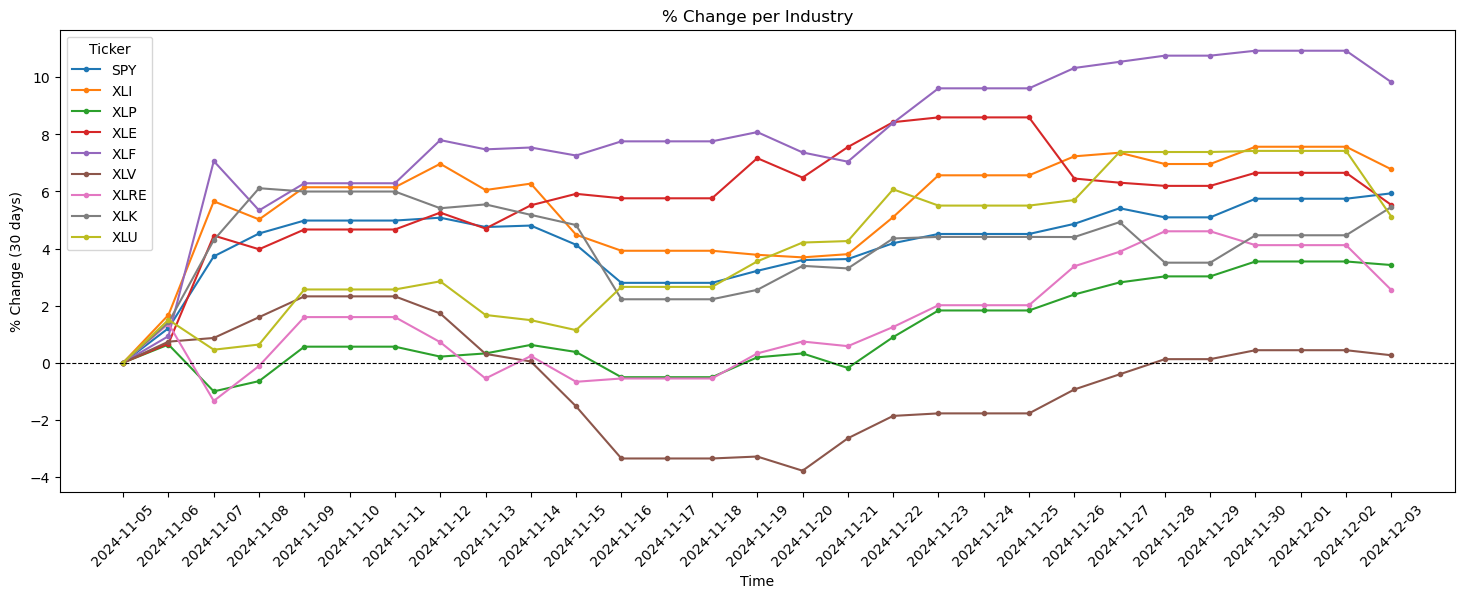

<Figure size 640x480 with 0 Axes>

In [218]:
plt.figure(figsize=(18, 6))
for ticker in df_sectors.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_sectors.columns[2:],
        df_sectors.loc[ticker].values[2:],
        label=ticker,
        marker="o",
        markersize=3,
    )

plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (30 days)")
plt.xticks(rotation=45)
plt.title("% Change per Industry")
plt.show()
plt.savefig("sector_returns")

# plt.figure(figsize=(20, 6))

# # Define the highlight colors
# highlight_colors = {"SPY": "orange", "portfolio": "blue"}
# default_color = "light grey"

# # Plot each ticker's data
# for ticker in df_sectors.index:
#     color = highlight_colors.get(
#         ticker, default_color
#     )  # Use highlight color if ticker matches, otherwise grey
#     plt.plot(
#         df_sectors.columns[1:],
#         df_sectors.loc[ticker].values[1:],
#         label=ticker,
#         marker="o",
#         markersize=3,
#         color=color,
#     )

# # Add a horizontal line at y=0
# plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)

# # Add labels, legend, and title
# plt.legend(title="Ticker")
# plt.xlabel("Time")
# plt.ylabel("% Change")
# plt.xticks(rotation=45)
# plt.title("% Change per Industry")
# plt.show()

In [219]:
sect_returns = df_sectors[1:][df_sectors.columns[-1]]
sect_returns.mean()
sect_returns

XLI     6.775730
XLP     3.421675
XLE     5.526401
XLF     9.831468
XLV     0.258901
XLRE    2.545114
XLK     5.457223
XLU     5.116586
Name: 2024-12-03, dtype: float64

avg sect return (unweighted) is 5.57 (as of 12/03)

### PORTFOLIO VS SPY -

In [220]:
# Sum the values of each column (from the 3rd column onward)
column_sums = df_updated.iloc[:, 2:].mean(axis=0)

# Create a new DataFrame with the same columns
df_avgs = pd.DataFrame(
    column_sums
).T  # Transpose to match the structure of the original DataFrame
df_avgs.columns = df_updated.columns[
    2:
]  # Assign the column names from the 3rd column onward

# Add the two new index values: 'portfolio name' and 'SPY'
df_avgs.index = ["portfolio"]
spy_values = ["NaN", "NaN", "NaN"]

# Iterate over the columns from the 3rd column onward
for months in df_updated.columns[3:]:
    if isinstance(months, str):
        month = datetime.strptime(months, "%Y-%m-%d")
    else:
        month = months  # Already a datetime object
    month = datetime.strptime(months, "%Y-%m-%d")
    spy_value = get_returns("SPY", month).values[0]
    spy_values.append(spy_value)

spy_values = pd.DataFrame([spy_values])
spy_values.columns = df_updated.columns
spy_values.index = ["SPY"]
df_avgs = pd.concat([df_avgs, spy_values])
df_avgs

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,...,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,Company Name,Capped_weight
portfolio,NaN,0.0,1.710512,5.790713,6.035509,7.738692,7.738692,7.738692,9.067958,7.783809,...,9.453832,9.763086,9.784461,9.784461,10.509386,10.520907,10.497220,10.227334,NaN,NaN
SPY,NaN,0.0,1.209178,3.725800,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,...,4.864785,5.412335,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,NaN,NaN


SPY returns is 5.93
portfolio returns is 10.22

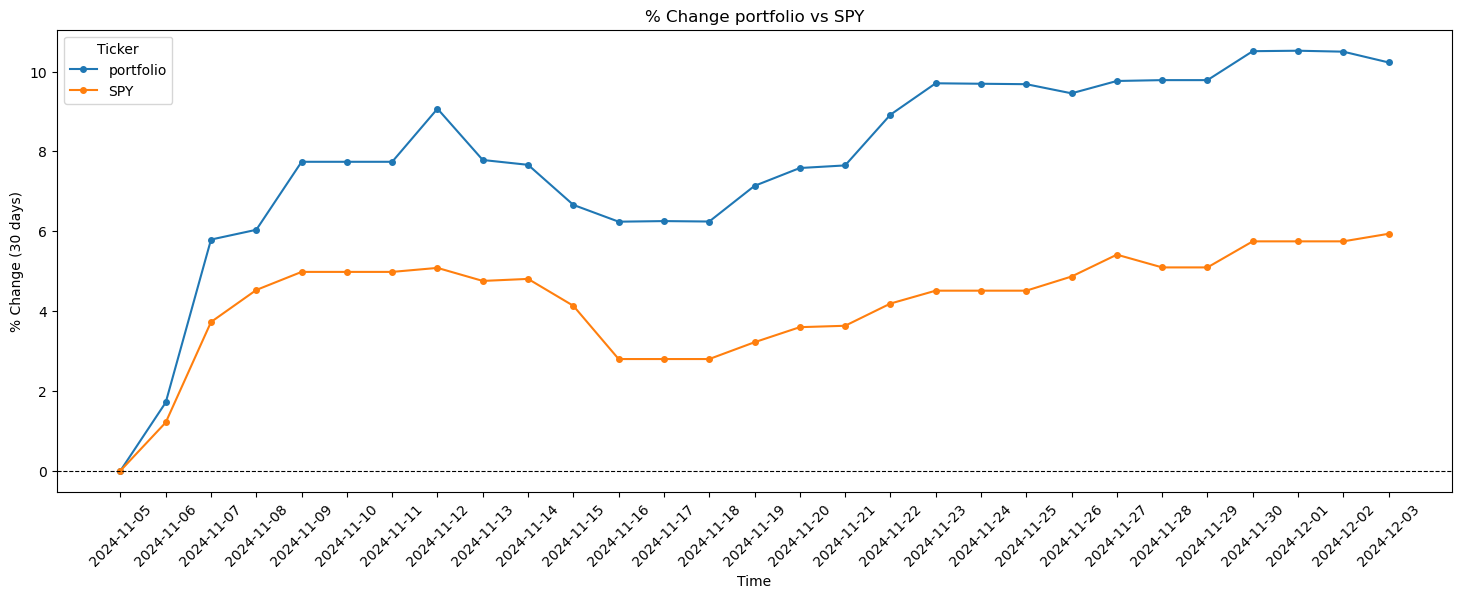

In [221]:
plt.figure(figsize=(18, 6))
for ticker in df_avgs.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_avgs.columns[1:-2],
        df_avgs.loc[ticker].values[1:-2],
        label=ticker,
        marker="o",
        markersize=4,
    )
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (30 days)")
plt.title("% Change portfolio vs SPY")
plt.xticks(rotation=45)
plt.show()